<center><b><h1>MiniVQA</h1></b></center>


**MiniVQA** is based on the VQA dataset [1] using microsoft COCO images [2]

[1] Goyal, Y., Khot, T., Summers-Stay, D., Batra, D., & Parikh, D. (2017). Making the v in vqa matter: Elevating the role of image understanding in visual question answering. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 6904-6913).

[2] Lin, T. Y., Maire, M., Belongie, S., Hays, J., Perona, P., Ramanan, D., ... & Zitnick, C. L. (2014, September). Microsoft coco: Common objects in context. In European conference on computer vision (pp. 740-755). Springer, Cham.

**Python 3.7.10**

# Step 1. Downloading VQA annotations (questions and answers)

In [1]:
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip && unzip v2_Annotations_Train_mscoco && \
wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip && unzip v2_Questions_Train_mscoco

--2023-05-01 07:51:26--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.196.176, 52.217.163.16, 52.217.159.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.196.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21708861 (21M) [application/zip]
Saving to: ‘v2_Annotations_Train_mscoco.zip’

v2_Annotations_Trai 100%[===================>]  20.70M  17.1MB/s    in 1.2s    

2023-05-01 07:51:28 (17.1 MB/s) - ‘v2_Annotations_Train_mscoco.zip’ saved [21708861/21708861]

Archive:  v2_Annotations_Train_mscoco.zip
  inflating: v2_mscoco_train2014_annotations.json  
--2023-05-01 07:51:30--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.170.56, 52.217.195.96, 52.216.153.30, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.170.56|:443... connected.
HTTP request sent, awaiting r

In [2]:
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import json
import copy
import glob
import torch
import random
import operator
import numpy as np
import urllib.request
import matplotlib.pyplot as plt


from PIL import Image
from tqdm import tqdm
from google.colab import files
from numpy.random import choice
from sklearn.manifold import TSNE
from collections import Counter, defaultdict


# Step 2. Unpacking questions

In [3]:
annotations = json.load(open("v2_mscoco_train2014_annotations.json"))
questions = json.load(open("v2_OpenEnded_mscoco_train2014_questions.json"))

In [4]:
annotations

{'info': {'description': 'This is v2.0 of the VQA dataset.',
  'url': 'http://visualqa.org',
  'version': '2.0',
  'year': 2017,
  'contributor': 'VQA Team',
  'date_created': '2017-04-26 17:07:13'},
 'license': {'url': 'http://creativecommons.org/licenses/by/4.0/',
  'name': 'Creative Commons Attribution 4.0 International License'},
 'data_subtype': 'train2014',
 'annotations': [{'question_type': 'what is this',
   'multiple_choice_answer': 'net',
   'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},
    {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2},
    {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3},
    {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4},
    {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5},
    {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6},
    {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7},
    {'answer': 'net', 'answer_confidence': 'yes', 'answer_

In [5]:
questions

{'info': {'description': 'This is v2.0 of the VQA dataset.',
  'url': 'http://visualqa.org',
  'version': '2.0',
  'year': 2017,
  'contributor': 'VQA Team',
  'date_created': '2017-04-26 17:07:13'},
 'task_type': 'Open-Ended',
 'data_type': 'mscoco',
 'license': {'url': 'http://creativecommons.org/licenses/by/4.0/',
  'name': 'Creative Commons Attribution 4.0 International License'},
 'data_subtype': 'train2014',
 'questions': [{'image_id': 458752,
   'question': 'What is this photo taken looking through?',
   'question_id': 458752000},
  {'image_id': 458752,
   'question': 'What position is this man playing?',
   'question_id': 458752001},
  {'image_id': 458752,
   'question': 'What color is the players shirt?',
   'question_id': 458752002},
  {'image_id': 458752,
   'question': 'Is this man a professional baseball player?',
   'question_id': 458752003},
  {'image_id': 262146,
   'question': 'What color is the snow?',
   'question_id': 262146000},
  {'image_id': 262146,
   'question'

In [6]:
annotations = annotations['annotations']
questions_id = {q['question_id']: q['question'] for q in questions['questions']} # mapping question_id to questions

assert len(annotations) == len(questions_id)
print(len(questions_id), 'questions available')

443757 questions available


In [7]:
annotations[0]

{'question_type': 'what is this',
 'multiple_choice_answer': 'net',
 'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 458752,
 'answer_type': 'other',
 'question_id': 458752000}

In [8]:
questions_id

{458752000: 'What is this photo taken looking through?',
 458752001: 'What position is this man playing?',
 458752002: 'What color is the players shirt?',
 458752003: 'Is this man a professional baseball player?',
 262146000: 'What color is the snow?',
 262146001: 'What is the person doing?',
 262146002: 'What color is the persons headwear?',
 524291000: "What is in the person's hand?",
 524291001: 'Is the dog waiting?',
 524291002: 'Is the dog looking at a tennis ball or frisbee?',
 393221000: 'Is the sky blue?',
 393221001: 'Is there snow on the mountains?',
 393221002: 'What is the white streak?',
 393223000: 'Is the window open?',
 393223001: 'What color is the toothbrush?',
 393223002: 'What is the child doing?',
 393223003: 'Is she brushing?',
 393224000: 'Is the man smiling?',
 393224001: 'What is the business man doing in the picture?',
 393224002: 'Does his tie pair well with his suit?',
 393224003: 'Does the man look happy?',
 393224004: 'Is this photo in color?',
 393224005:

[{'answer': '12', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': '8', 'answer_confidence': 'maybe', 'answer_id': 2}, {'answer': '3', 'answer_confidence': 'maybe', 'answer_id': 3}, {'answer': '12', 'answer_confidence': 'maybe', 'answer_id': 4}, {'answer': '9', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': '10', 'answer_confidence': 'maybe', 'answer_id': 6}, {'answer': '8', 'answer_confidence': 'maybe', 'answer_id': 7}, {'answer': '10', 'answer_confidence': 'no', 'answer_id': 8}, {'answer': '6', 'answer_confidence': 'maybe', 'answer_id': 9}, {'answer': '500', 'answer_confidence': 'no', 'answer_id': 10}]
[{'answer': 'pelicans', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'crane', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'pelicans', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'storks', 'answer_confidence': 'maybe', 'answer_id': 4}, {'answer': 'pelicans', 'answer_confidence': 'no', 'answer_id': 5}, {'answer': 'herons', 'answer_confid

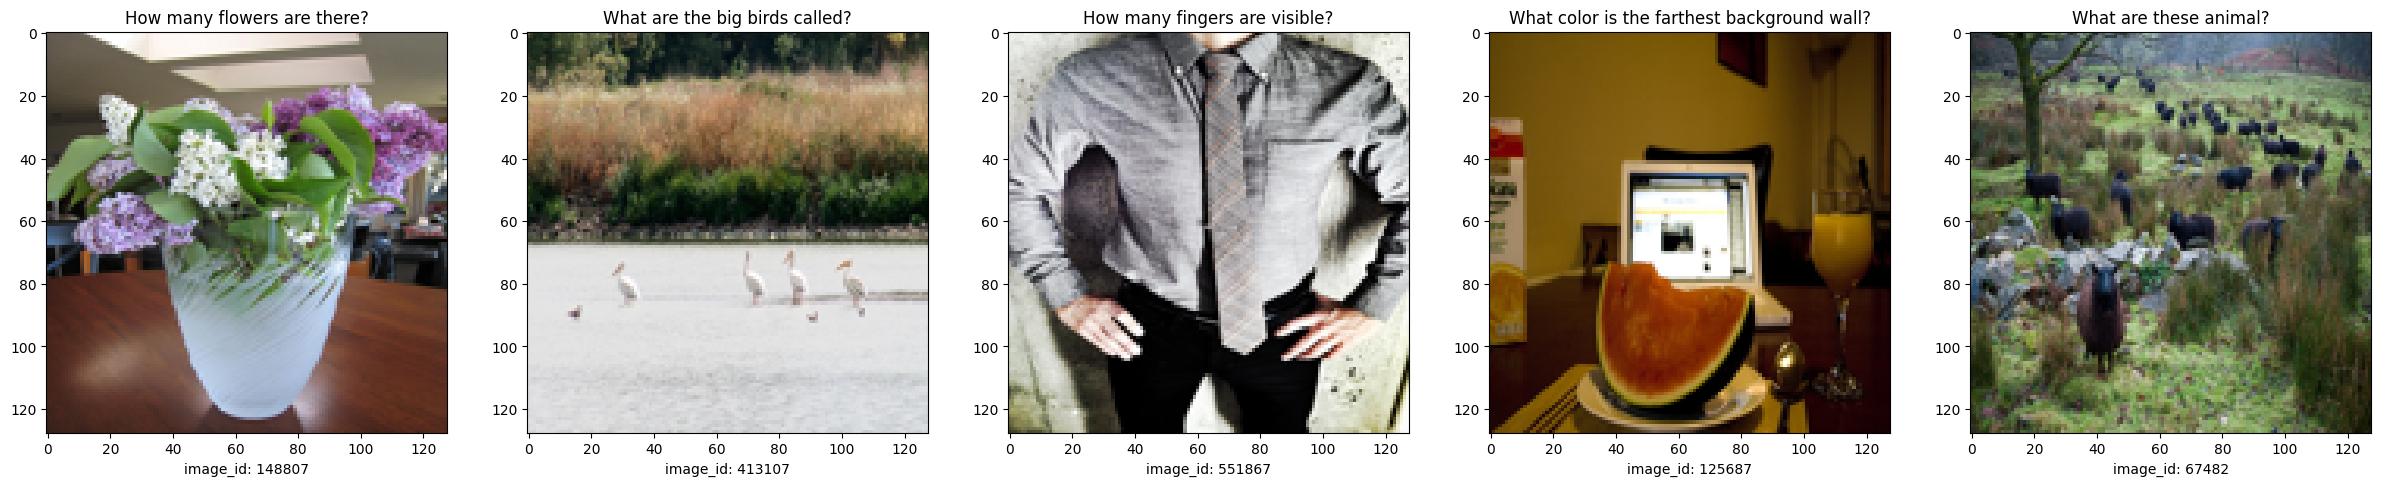

In [9]:
# Printing 5 random examples 
plt.figure(figsize=([30, 20]))
for i in range(5):
  plt.subplot(1, 5, i+1)
  ann = random.choice(list(annotations)) # choosing randomly one of annotations (10 answers to 1 question)
  filename = 'COCO_train2014_'+ str(ann['image_id']).zfill(12) + '.jpg' # finding its corresponding image
  src = os.path.join('https://vqa_mscoco_images.s3.amazonaws.com/train2014/', filename)
  trg = os.path.join('/tmp', filename)
  if not os.path.exists(trg):
    urllib.request.urlretrieve(src, trg)
  print(ann['answers'])
  plt.imshow(Image.open(trg).resize((128,128)))
  plt.xlabel('image_id: '+ str(ann['image_id']))
  plt.title(questions_id[ann['question_id']])

# Step 3. Group questions by answers 

In [10]:
questions_by_answer_type = defaultdict(list)

# Get most frequent answer amongst annotators 
def get_top_answer(answers):
#   count_answers = Counter([answer['answer'] for answer in annotation['answers']])
  count_answers = Counter([answer['answer'] for answer in answers])
  top_answer, _ = count_answers.most_common()[0]
  return top_answer

# Iterate through annotations
# Stack questions
for annotation in tqdm(annotations, position=0, leave=True):
  question_id =  annotation['question_id']
  image_id =  annotation['image_id']
  top_answer = get_top_answer(annotation['answers'])
  questions_by_answer_type[top_answer].append([questions_id[question_id], int(image_id), int(question_id)])

# we discard answers with less than 3 samples. We want at least one sample per slip (train,val,test)
answers_population = Counter({a:len(q) for a, q in questions_by_answer_type.items() if len(q) > 3})
num_unique_answers = len(answers_population)
print('\n', num_unique_answers, 'unique answers')

100%|██████████| 443757/443757 [00:03<00:00, 111842.60it/s]


 4547 unique answers


In [11]:
questions_by_answer_type

Output hidden; open in https://colab.research.google.com to view.

In [12]:
answers_population

Counter({'net': 34,
         'pitcher': 91,
         'orange': 1408,
         'yes': 82981,
         'white': 9018,
         'skiing': 882,
         'red': 5352,
         'frisbee': 1642,
         'white and purple': 4,
         'brushing teeth': 127,
         'no': 84572,
         'frowning': 6,
         'black and white': 817,
         'skateboard': 696,
         '1': 12257,
         'blue': 5200,
         'green': 3774,
         'motorcycle': 497,
         '2': 12514,
         'purse': 88,
         'gray': 1990,
         'poles': 60,
         'surfboard': 624,
         'background': 123,
         'office': 172,
         'large': 84,
         'very big': 10,
         'laptop': 542,
         'vent': 21,
         'document': 4,
         'black': 5176,
         'bear': 430,
         '3': 6269,
         'wii': 642,
         'glasses': 221,
         'tree': 299,
         'eating': 587,
         'log': 28,
         'homeless': 5,
         'automatic': 4,
         '5': 2341,
         'raft'

# Step 4. Decide the volume of your dataset

1. select **num_answers**, the number of possible different answers (i.e. how many classes)
2. select the **sampling_type** to choose answers ("top" to get the '*num_answers*' most common answers, or "random")  
3. you can choose to exclude the n most popular answers with **sampling_exclude_top** (the most popular answers is "no" and contains 80.000 questions). You can do the same, for bottom answers, with **sampling_exclude_bottom**.
4. if *sampling_type* is random, you can choose a minimum and maximum number of questions with **min_samples** and **max_samples**

In [13]:
num_answers = 10
sampling_type = "top" # choose between top or random
sampling_exclude_top = 50
sampling_exclude_bottom = 50
min_samples = 3000
max_samples = 4000

After adjusting parameters, run the following cell to display the results.
Restart the cell to generate new results.

In [14]:
top = answers_population.most_common()
print(top)

[('no', 84572), ('yes', 82981), ('2', 12514), ('1', 12257), ('white', 9018), ('3', 6269), ('red', 5352), ('blue', 5200), ('black', 5176), ('0', 5001), ('4', 4370), ('green', 3774), ('brown', 3595), ('yellow', 2834), ('5', 2341), ('gray', 1990), ('nothing', 1860), ('left', 1684), ('right', 1668), ('frisbee', 1642), ('6', 1623), ('baseball', 1607), ('tennis', 1496), ('wood', 1470), ('orange', 1408), ('none', 1316), ('bathroom', 1219), ('pizza', 1218), ('pink', 1128), ('kitchen', 1113), ('7', 990), ('8', 966), ('man', 951), ('cat', 937), ('grass', 904), ('skateboarding', 897), ('dog', 895), ('water', 884), ('skiing', 882), ('silver', 821), ('black and white', 817), ('10', 801), ('kite', 790), ('surfing', 747), ('horse', 704), ('skateboard', 696), ('living room', 689), ('phone', 656), ('snow', 643), ('wii', 642), ('giraffe', 638), ('surfboard', 624), ('woman', 607), ('cake', 605), ('sunny', 594), ('broccoli', 590), ('eating', 587), ('table', 584), ('hat', 576), ('apple', 576), ('stop', 562

In [15]:
top_answers = [a[0] for a in top]
print(top_answers)

['no', 'yes', '2', '1', 'white', '3', 'red', 'blue', 'black', '0', '4', 'green', 'brown', 'yellow', '5', 'gray', 'nothing', 'left', 'right', 'frisbee', '6', 'baseball', 'tennis', 'wood', 'orange', 'none', 'bathroom', 'pizza', 'pink', 'kitchen', '7', '8', 'man', 'cat', 'grass', 'skateboarding', 'dog', 'water', 'skiing', 'silver', 'black and white', '10', 'kite', 'surfing', 'horse', 'skateboard', 'living room', 'phone', 'snow', 'wii', 'giraffe', 'surfboard', 'woman', 'cake', 'sunny', 'broccoli', 'eating', 'table', 'hat', 'apple', 'stop', 'food', 'elephant', 'laptop', 'purple', 'standing', '9', 'beach', '12', 'snowboarding', 'train', 'sheep', 'motorcycle', 'banana', 'soccer', 'trees', 'bus', 'male', 'cow', 'wine', 'flowers', 'tan', 'umbrella', 'winter', 'bear', 'camera', 'walking', 'sitting', 'metal', 'female', 'tile', '20', 'brick', 'outside', 'plane', 'car', 'clear', 'night', 'cloudy', 'donut', 'bed', 'many', 'summer', 'bananas', 'zebra', 'bird', 'bench', 'sandwich', 'down', 'hot dog', 

In [16]:
answers = top_answers[sampling_exclude_top:num_answers + sampling_exclude_top]
print(answers)

['giraffe', 'surfboard', 'woman', 'cake', 'sunny', 'broccoli', 'eating', 'table', 'hat', 'apple']


In [17]:
max_possible_samples = [answers_population[a] for a in answers]
print(max_possible_samples)

[638, 624, 607, 605, 594, 590, 587, 584, 576, 576]


In [18]:
sum(max_possible_samples)

5981

Chosen answers: ['giraffe', 'surfboard', 'woman', 'cake', 'sunny', 'broccoli', 'eating', 'table', 'hat', 'apple']
Num samples: 5981
Labels distribution:


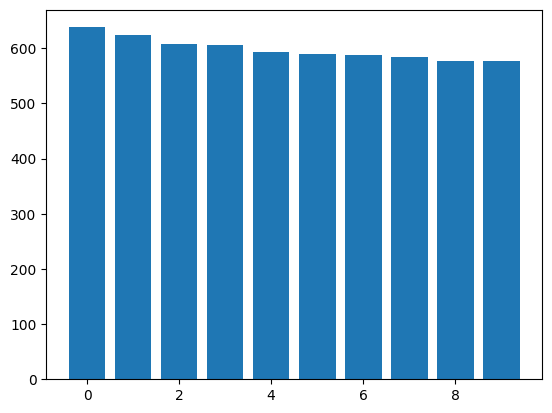

[('giraffe', 638), ('surfboard', 624), ('woman', 607), ('cake', 605), ('sunny', 594), ('broccoli', 590), ('eating', 587), ('table', 584), ('hat', 576), ('apple', 576)]

Unhappy ? restart cell...


In [19]:
def get_answers(num_answers, sampling_type, min_samples, sampling_exclude_top):
  assert (num_unique_answers - sampling_exclude_top) > num_answers, "too big sampling_exclude_top, not enough answer left for num_answers"
  assert min_samples < max_samples

  top = answers_population.most_common()
  top_answers = [a[0] for a in top]

  if sampling_type == 'top':
    answers = top_answers[sampling_exclude_top:num_answers + sampling_exclude_top]
    max_possible_samples = [answers_population[a] for a in answers]

  elif sampling_type == 'random':
    # select random answers
    rand_index = random.sample(range(sampling_exclude_top, num_unique_answers), num_answers)
    answers = [top_answers[r] for r in rand_index]

    # compute the number of samples available
    max_possible_samples = [answers_population[a] for a in answers]

    swaps = 0
    pbar = tqdm(10000, position=0, leave=True)

    while sum(max_possible_samples) < min_samples or sum(max_possible_samples) > max_samples:
      a = random.choice(answers)
      index = top_answers.index(a)

      if sum(max_possible_samples) < min_samples:
        # Fitting a response with higher population
        min_index = sampling_exclude_top
        if index <= sampling_exclude_top: #cant do better
          continue
        new_answer = top_answers[random.randint(min_index, index-1)] 
      else:
        # Fitting a response with lower population
        max_index = len(top_answers) - sampling_exclude_bottom
        if index >= max_index: #cant do better
          continue
        new_answer = top_answers[random.randint(index+1, max_index)]

      if new_answer in answers: # already have this answer
        continue

      answers.remove(a)
      answers.append(new_answer)

      # update num of samples
      max_possible_samples = [answers_population[a] for a in answers]

      swaps +=1
      if swaps == int(10e3):
        raise StopIteration("Too much iterations, it possible there is no configuration for your scenario")
      pbar.update(1)
      pbar.set_description('current_samples:{}'.format(sum(max_possible_samples)))
    print("\ndone!")
  else:
    raise NotImplementedError()
  dataset = {a:q for a, q in questions_by_answer_type.items() if a in answers}
  return dataset, answers, max_possible_samples


dataset, answers, max_possible_samples = get_answers(num_answers, sampling_type, min_samples, sampling_exclude_top)

assert len(set(answers)) == num_answers, "Something went wrong, let's try again"


# Print results
print("Chosen answers:", answers)
print("Num samples:", sum(max_possible_samples))
print("Labels distribution:")

plt.bar(range(num_answers), max_possible_samples)
plt.show()
print(Counter({a:len(q) for a, q in dataset.items()}).most_common())
print('\nUnhappy ? restart cell...')


In [20]:
print("Chosen answers:", answers)
print("Num samples:", sum(max_possible_samples))
print("Labels distribution:")
print(Counter({a:len(q) for a, q in dataset.items()}).most_common())

Chosen answers: ['giraffe', 'surfboard', 'woman', 'cake', 'sunny', 'broccoli', 'eating', 'table', 'hat', 'apple']
Num samples: 5981
Labels distribution:
[('giraffe', 638), ('surfboard', 624), ('woman', 607), ('cake', 605), ('sunny', 594), ('broccoli', 590), ('eating', 587), ('table', 584), ('hat', 576), ('apple', 576)]


# Step 5. Create dataset files


1.   **Samples clipping** : Set to select maximum n samples per answer
2.   **im_download**: You can choose to download images directly through http request. This process might be slow if you picked a lot of samples. Might as well get a cup of coffee.

In [21]:
im_download=False
sample_clipping=100 # false for no clipping

In [22]:
dataset

{'surfboard': [['What is the dog riding on?', 131087, 131087000],
  ['What is this man laying on?', 471373, 471373004],
  ['What is lying on the ground?', 474858, 474858009],
  ['What is the man holding in his right hand?', 262545, 262545002],
  ['What does the person have in their hand?', 475765, 475765004],
  ['What is the little boy on?', 263278, 263278000],
  ['What is the man riding?', 263278, 263278001],
  ['What is the man riding?', 1639, 1639003],
  ['What object is the man holding in his hand?', 264091, 264091003],
  ['What is the man holding?', 133508, 133508000],
  ['What kind of board is this?', 527656, 527656000],
  ['What type of board is the business name written on?', 527656, 527656004],
  ['What is the man carrying?', 371939, 371939000],
  ['What is the red object?', 459339, 459339006],
  ['What is this man holding?', 134697, 134697002],
  ['What is the man standing on?', 78684, 78684006],
  ['What is the artwork sitting on?', 528131, 528131003],
  ['What is the person

In [23]:
dataset.keys()

dict_keys(['surfboard', 'eating', 'cake', 'table', 'hat', 'giraffe', 'broccoli', 'woman', 'sunny', 'apple'])

In [24]:
image_question = defaultdict(list)
label_question = defaultdict(list)
question_label = {}
answer_list = list(dataset.keys())

im_dir = "data/images"
os.makedirs(im_dir, exist_ok=True)
pbar = tqdm(dataset.items(), position=0, leave=True)

for answer, questions in pbar:
  if sample_clipping:
    questions = questions[:sample_clipping]

  for i, q in enumerate(questions):
    question, image_id, question_id = q
    if im_download:
      filename = 'COCO_train2014_'+ str(image_id).zfill(12) + '.jpg'
      pbar.set_description("Downloading images for answer {} [{}/{}] {}".format(answer, i, len(questions), filename))
      src = os.path.join('https://vqa_mscoco_images.s3.amazonaws.com/train2014/', filename)
      trg = os.path.join(im_dir, filename)
      if not os.path.exists(trg):
        urllib.request.urlretrieve(src, trg)

    # Filling dict
    image_question[image_id].append((question_id, question))
    label_question[answer].append(question_id)
    question_label[question_id] = answer_list.index(answer)
  
print('\n')
print(len(image_question), 'images for', len(question_label), 'questions')

print('five samples of image_question', list(image_question.items())[:5])
print('five samples of question_label', list(question_label.items())[:5])
print('five samples of label_question', list(label_question.items())[:5])



100%|██████████| 10/10 [00:00<00:00, 4107.63it/s]



836 images for 1000 questions
five samples of image_question [(131087, [(131087000, 'What is the dog riding on?')]), (471373, [(471373004, 'What is this man laying on?')]), (474858, [(474858009, 'What is lying on the ground?')]), (262545, [(262545002, 'What is the man holding in his right hand?')]), (475765, [(475765004, 'What does the person have in their hand?')])]
five samples of question_label [(131087000, 0), (471373004, 0), (474858009, 0), (262545002, 0), (475765004, 0)]
five samples of label_question [('surfboard', [131087000, 471373004, 474858009, 262545002, 475765004, 263278000, 263278001, 1639003, 264091003, 133508000, 527656000, 527656004, 371939000, 459339006, 134697002, 78684006, 528131003, 134948000, 153572011, 528471000, 460055003, 460055005, 460055007, 529340002, 398596008, 5425000, 5740001, 399241010, 399885011, 531459002, 269490001, 310128002, 7535002, 7535020, 400829000, 7650000, 138749000, 139389001, 154349011, 285473002, 88875001, 525790007, 140473000, 271729000,

# Step 6 (optional). Resize images

For your mini-VQA project, you might want to use lower resolution for your images (faster training).

1.   **resize** : Squared resize of n pixels

In [25]:
resize = 128

In [26]:
im_dir = "data/images"
outdir = "data/images_resized"
os.makedirs(outdir, exist_ok=True)

images = glob.glob(os.path.join(im_dir, '*'))
for im in tqdm(images, position=0, leave=True):
  try:
    im_resized = os.path.basename(im).replace(".jpg", "_resized.jpg")
    image = Image.open(im)
    image = image.resize((resize,resize), Image.ANTIALIAS)
    image.save(os.path.join(outdir, im_resized), "JPEG")
  except Exception as e:
    print(e)
    print("Its possible the image is corrupted, re-download it")
    raise


0it [00:00, ?it/s]


# Step 7. Explore the question embedding space
Compute embeddings using a pretrained bert-base-nli-mean-tokens. Feel free to change the model.


In [27]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.5 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=5f27d8dc685c2ac9808c5c74686c5e1ebed915582e9f726ab18ceebfef5472d0
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [28]:
from sentence_transformers import SentenceTransformer
print("Computing embeddings of selected questions")
model = SentenceTransformer('bert-base-nli-mean-tokens').cuda().eval() 

qs = [q[1] for  _, v in image_question.items() for q in v]
ids = [q[0] for  _, v in image_question.items() for q in v]
at = {ann['question_id']:ann['question_type'] for ann in annotations}

sentence_embeddings = []
ans_type = []
for q, id in tqdm(zip(qs, ids), position=0, leave=True, total=len(qs)):
  with torch.no_grad():
    sentence_embeddings.append(model.encode(q))
  ans_type.append(at[id])
    
sentence_embeddings = np.array(sentence_embeddings)
ans_type = np.array(ans_type)

# # Reduce dimension
sentence_embeddings = np.array(sentence_embeddings)
viz = TSNE(n_components=2, n_jobs=4, verbose=1, n_iter=2000)
embeddings = viz.fit_transform(sentence_embeddings)

Computing embeddings of selected questions


100%|██████████| 1000/1000 [00:19<00:00, 50.57it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.102s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.881547
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.514133
[t-SNE] KL divergence after 2000 iterations: 0.432176


<ipython-input-29-200707152cc6>:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_q_type = random.sample(set(ans_type), 5)
<ipython-input-29-200707152cc6>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[ix, 0], embeddings[ix, 1], s=0.1,


<Figure size 640x480 with 0 Axes>

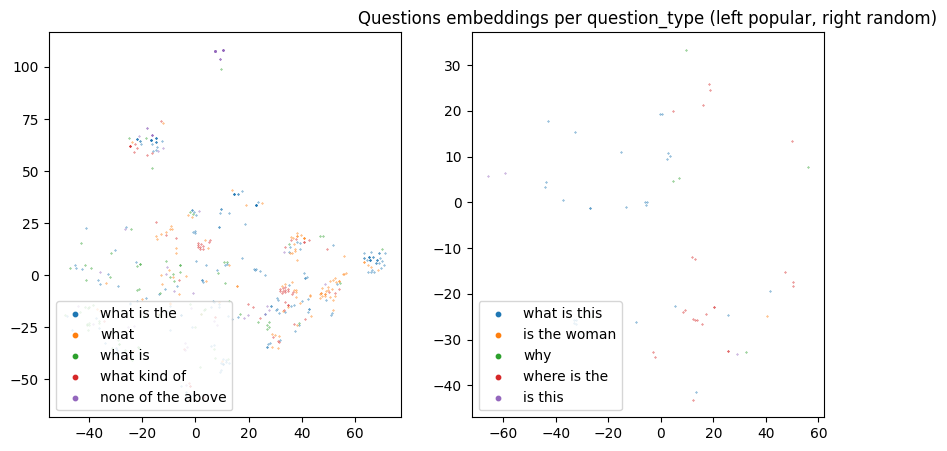

In [29]:
# Plotting
fig = plt.figure()
best_q_type = [k[0] for k in Counter(ans_type).most_common(5)]
random_q_type = random.sample(set(ans_type), 5)
plt.figure(figsize=([10, 5]))
for i, q_type in enumerate([best_q_type, random_q_type]):
  plt.subplot(1, 2, i+1)
  for g in q_type:
      ix = np.where(ans_type == g)
      plt.scatter(embeddings[ix, 0], embeddings[ix, 1], s=0.1,
                  cmap='Spectral', label=g)
  plt.legend(markerscale=10, loc='lower left')
plt.title("Questions embeddings per question_type (left popular, right random)")
plt.show()

# Step 8. Create split

1. You can choose train and validation size, rest is test
2. You can choose whether labels are homogeneously distributed across splits by setting **balanced** to True. False otherwise. 


In [30]:
train_size = 0.8
val_size = 0.1
balanced = True

Label repartition across splits


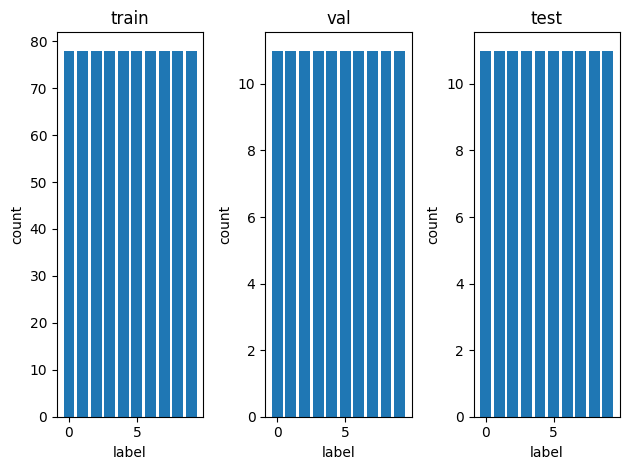

In [31]:
assert sum([train_size, val_size]) < 1.0

train = []
val = []
test = []

lq = copy.deepcopy(label_question)

# put at least one sample of each answer in each split
for _, v in  lq.items():
  random.shuffle(v)    
  train.append(v.pop())
  val.append(v.pop())
  test.append(v.pop())

if balanced:
  # generating balanced splits, for each label, put the requested balance in splits
  for _, v in  lq.items():
    random.shuffle(v)
    num_samples = len(v)
    train += (v[:int(train_size*num_samples)])
    val   += (v[int(train_size*num_samples):int((train_size+val_size)*num_samples)])
    test  += (v[int((train_size+val_size)*num_samples):])
else:
    all_qid = [item for _, v in lq.items() for item in v]
    labels = list(lq.keys())
    num_samples = len(all_qid)

    random_weights = np.random.random(len(labels))

    while len(val) < int(val_size*num_samples):
      label_drawn = choice(labels, 1, p=random_weights/random_weights.sum())
      sample = random.choice(lq[label_drawn[0]])
      if sample in all_qid:
        val.append(sample)
        all_qid.remove(sample)

    random_weights = np.random.random(len(labels))

    while len(test) < int((1-(val_size+train_size))*num_samples):
      label_drawn = choice(labels, 1, p=random_weights/random_weights.sum())
      sample = random.choice(lq[label_drawn[0]])
      if sample in all_qid:
        test.append(sample)
        all_qid.remove(sample)
    
    train += all_qid

random.shuffle(train)
random.shuffle(val)
random.shuffle(test)

# assert no duplicates
assert len(set(train + val + test)) == (len(train) + len(val) + len(test))

for i, name in enumerate(['train', 'val', 'test']):
  split = eval(name)
  label_count = Counter()
  for q in split:
    label_count[question_label[q]] += 1
  plt.subplot(1, 3, i+1)
  plt.bar(range(len(label_count)), [label_count[i] for i in range(len(label_count))])
  plt.xlabel("label")
  plt.ylabel("count")
  plt.title(name)

plt.tight_layout()
print("Label repartition across splits")
plt.show()

# Last Step: download files

1. **test.csv** must be given to students. They have to fill it with their prediction formatted like **sample_submission.csv** which contains random predictions
2. **answer_key.csv** is the ground-truth file that has to be stored on kaggle
3. **answer_list.csv** maps the label to the answer in natural language (i.e. label 0 is answer at line 1 in answer_list, etc.)
3. **image_question.json** maps an image_id to a list of questions (that concerns image_id). Each question is a tuple (question_id, question). <br/>
To map an image_id to its corresponding image_file, do :
```
COCO_train2014_'+ str(image_id).zfill(12) + '.jpg
```



In [32]:
for fn, ids in [["train.csv", train], ["val.csv", val], ["test.csv", test], ["answer_key.csv", test], ["sample_submission.csv", test]]:
  lines = []
  for id in ids:
    # for sample_submission, choose random label
    if 'sample_submission' in fn:
      lines.append(str(id) +','+str(random.randint(0, len(label_question.keys())-1)))
    # for test.csv, dont print label
    elif 'test' in fn:
      lines.append(str(id))
    else:
      lines.append(str(id) +','+str(question_label[id]))
  
  open(fn, "w+").write('question_id,label\n'+'\n'.join(map(str, lines)))
  files.download(fn) 


open("answer_list.txt", "w+").write('\n'.join(map(str, answer_list)))
files.download('answer_list.txt') 

json.dump(image_question, open('image_question.json', 'w'))
files.download('image_question.json') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If you have downloaded images, download your zip (the folder is data/images or data/images_resized if you resized images)

In [ ]:
!zip -r -q images.zip data/images_resized

In [ ]:
files.download("images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>